In [2]:
!unzip /content/drive/MyDrive/garbage_classification-20260213T085610Z-1-001.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/garbage_classification/clothes/clothes4501.jpg  
  inflating: /content/garbage_classification/clothes/clothes3560.jpg  
  inflating: /content/garbage_classification/clothes/clothes3900.jpg  
  inflating: /content/garbage_classification/clothes/clothes4591.jpg  
  inflating: /content/garbage_classification/clothes/clothes455.jpg  
  inflating: /content/garbage_classification/clothes/clothes4535.jpg  
  inflating: /content/garbage_classification/clothes/clothes3371.jpg  
  inflating: /content/garbage_classification/clothes/clothes4620.jpg  
  inflating: /content/garbage_classification/clothes/clothes3603.jpg  
  inflating: /content/garbage_classification/clothes/clothes4072.jpg  
  inflating: /content/garbage_classification/clothes/clothes3681.jpg  
  inflating: /content/garbage_classification/clothes/clothes3800.jpg  
  inflating: /content/garbage_classification/clothes/clothes3799.jpg  
  inflating: /content/garba

In [3]:
!pip install tensorflow scikit-learn seaborn opencv-python

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [5]:
import tensorflow as tf

data_dir = '/content/garbage_classification/'
image_size = (224, 224)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("Training dataset created successfully.")
print("Validation dataset created successfully.")

Found 15545 files belonging to 12 classes.
Using 12436 files for training.
Found 15545 files belonging to 12 classes.
Using 3109 files for validation.
Training dataset created successfully.
Validation dataset created successfully.


In [6]:
import tensorflow as tf

normalization_layer = tf.keras.layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomContrast(0.2)
])


normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

augmented_train_ds = normalized_train_ds.map(lambda x, y: (data_augmentation(x), y))

print("Normalization layer and data augmentation model defined.")
print("Datasets normalized and augmented as required.")

Normalization layer and data augmentation model defined.
Datasets normalized and augmented as required.


Found 15545 files belonging to 12 classes.
Using 12436 files for training.


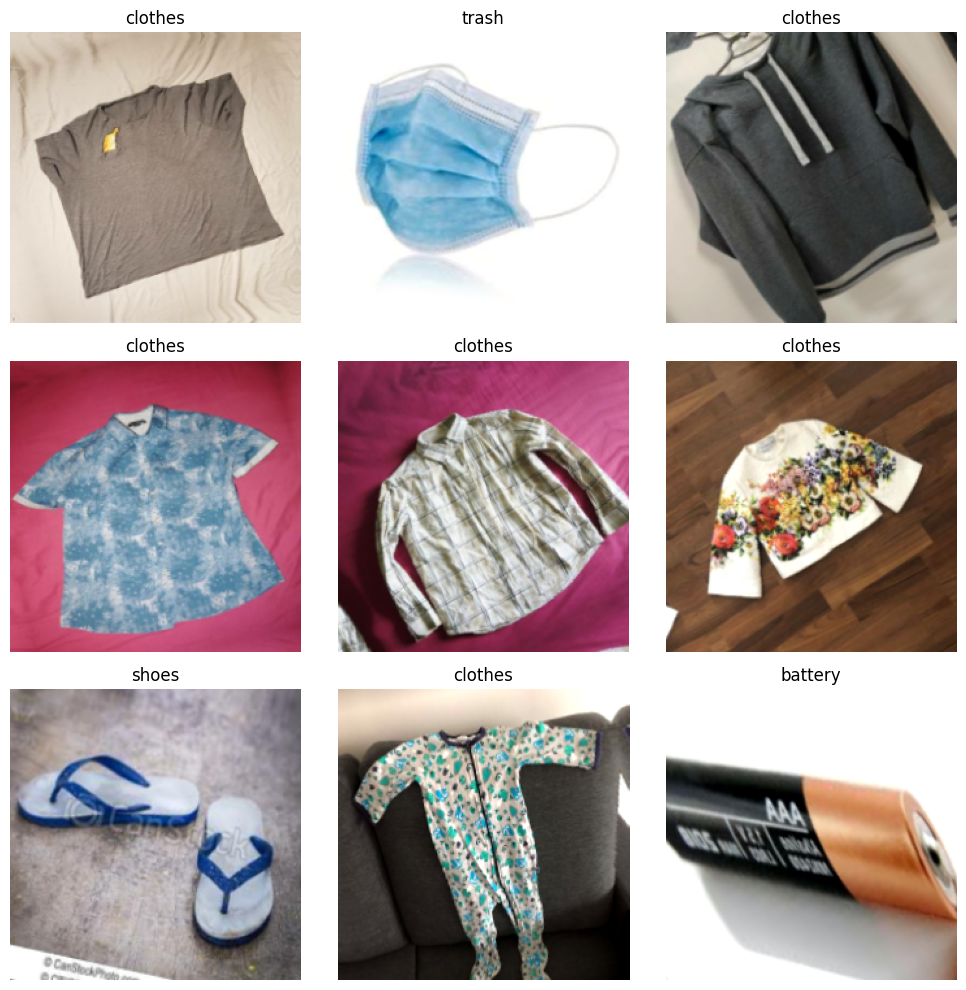

In [8]:
import matplotlib.pyplot as plt
import tensorflow as tf

temp_ds_for_class_names = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False
)
class_names = temp_ds_for_class_names.class_names

for images, labels in augmented_train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(min(len(images), 9)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    break

Found 15545 files belonging to 12 classes.
Using 12436 files for training.


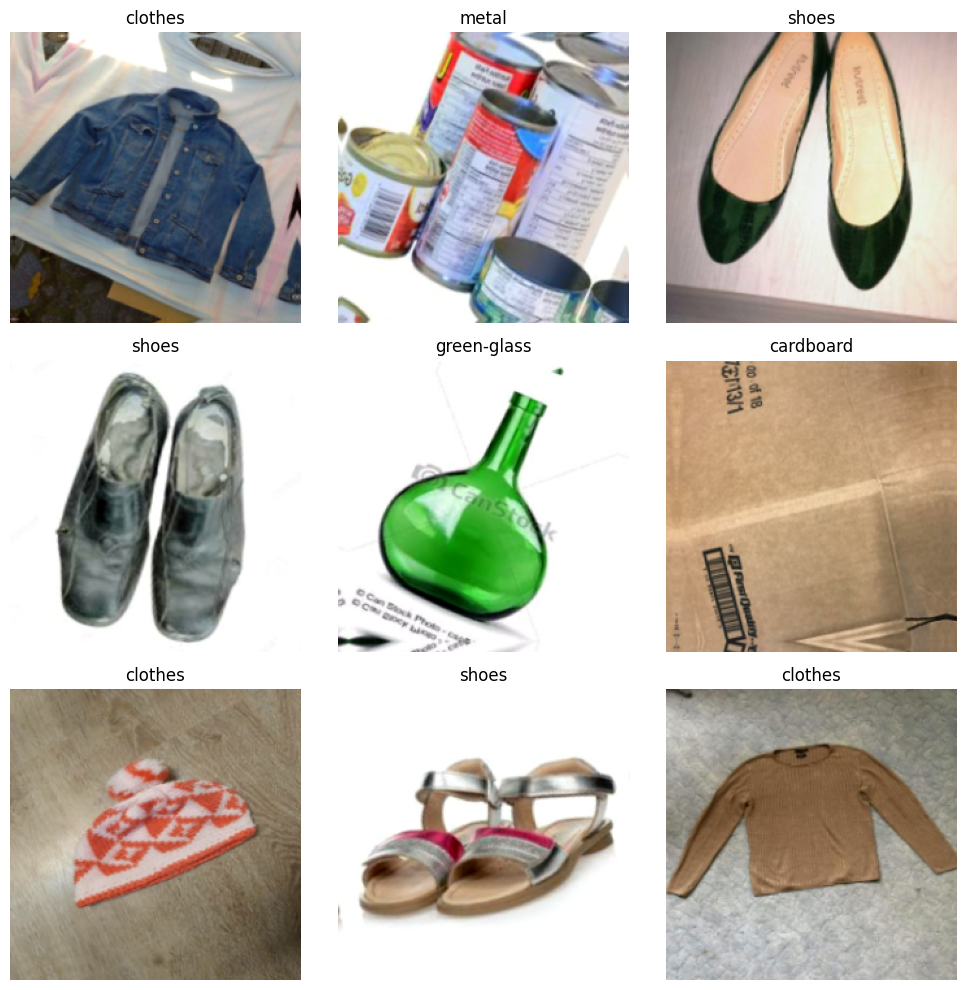

In [9]:
import matplotlib.pyplot as plt
import tensorflow as tf

temp_ds_for_class_names = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False
)
class_names = temp_ds_for_class_names.class_names

for images, labels in augmented_train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(min(len(images), 9)):
        ax = plt.subplot(3, 3, i + 1)
        clipped_image = tf.clip_by_value(images[i], 0.0, 1.0)
        plt.imshow(clipped_image.numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    break

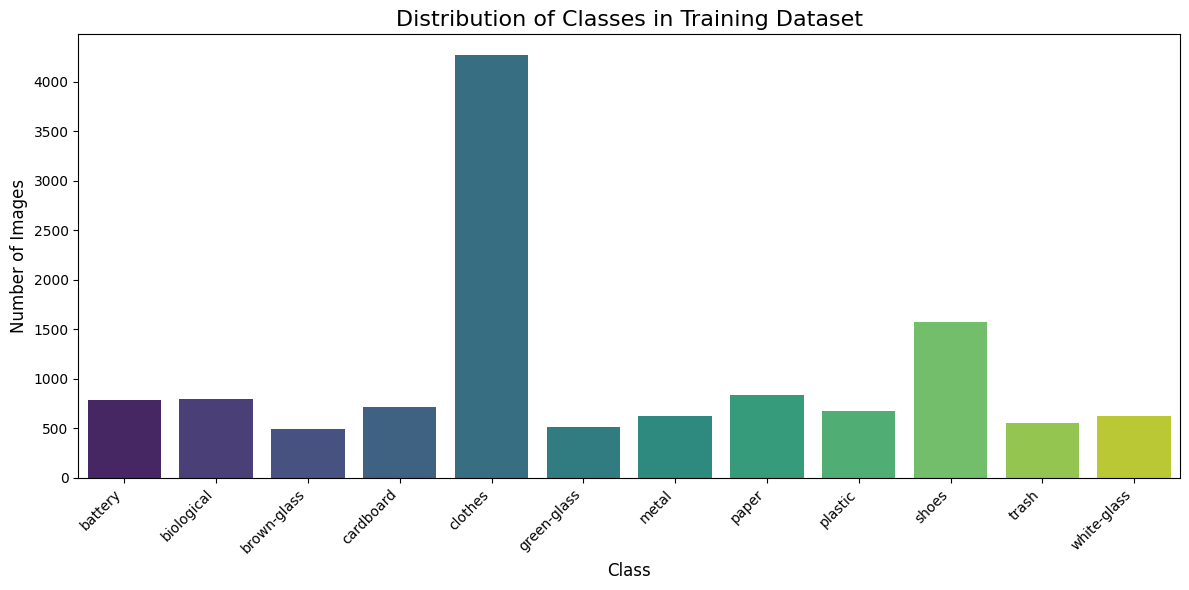

Class distribution chart generated successfully.


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

all_labels = []
for _, labels_batch in train_ds:
    all_labels.extend(labels_batch.numpy())

labels_np = np.array(all_labels)

class_counts = np.bincount(labels_np)

class_distribution = {class_names[i]: count for i, count in enumerate(class_counts)}

class_names_ordered = list(class_distribution.keys())
counts_ordered = list(class_distribution.values())

plt.figure(figsize=(12, 6))
sns.barplot(x=class_names_ordered, y=counts_ordered, hue=class_names_ordered, palette='viridis', legend=False)

plt.title('Distribution of Classes in Training Dataset', fontsize=16)

plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("Class distribution chart generated successfully.")

In [12]:
import tensorflow as tf

from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False

print("MobileNetV2 base model loaded and its layers frozen successfully.")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
MobileNetV2 base model loaded and its layers frozen successfully.


In [16]:
import tensorflow as tf

x = base_model.output

x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)

x = tf.keras.layers.Dropout(0.3)(x)

num_classes = len(class_names)
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=prediction_layer)

print("Custom classification head created and added to the MobileNetV2 base model.")


Custom classification head created and added to the MobileNetV2 base model.


In [17]:
import tensorflow as tf

model = tf.keras.Sequential([
    normalization_layer,
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

print("Sequential model created successfully, combining preprocessing, base model, and classification head.")
print("Model summary:")
model.summary()

Sequential model created successfully, combining preprocessing, base model, and classification head.
Model summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [18]:
import tensorflow as tf

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

print("Model compiled successfully with Adam optimizer, SparseCategoricalCrossentropy loss, and accuracy metric.")

Model compiled successfully with Adam optimizer, SparseCategoricalCrossentropy loss, and accuracy metric.


In [19]:
import tensorflow as tf
import os

os.makedirs('models', exist_ok=True)
print("Created 'models' directory if it didn't exist.")

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='models/best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=0.00001,
    mode='min',
    verbose=1
)

callbacks = [early_stopping, model_checkpoint, reduce_lr_on_plateau]

print("Keras callbacks initialized and stored in the 'callbacks' list successfully.")

Created 'models' directory if it didn't exist.
Keras callbacks initialized and stored in the 'callbacks' list successfully.


In [22]:
import tensorflow as tf

# Train the model
history = model.fit(
    augmented_train_ds,
    epochs=2,
    validation_data=normalized_val_ds,
    callbacks=callbacks
)

print("Model training completed and history stored.")

Epoch 1/2
389/389 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3496 - loss: 2.2095
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to models/best_model.h5


389/389 ━━━━━━━━━━━━━━━━━━━━ 975s 3s/step - accuracy: 0.3496 - loss: 2.2095 - val_accuracy: 0.0000e+00 - val_loss: 2.4875 - learning_rate: 0.0010
Epoch 2/2
389/389 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3496 - loss: 2.2061
Epoch 2: val_accuracy did not improve from 0.00000
389/389 ━━━━━━━━━━━━━━━━━━━━ 929s 2s/step - accuracy: 0.3496 - loss: 2.2061 - val_accuracy: 0.0000e+00 - val_loss: 2.5669 - learning_rate: 0.0010
Model training completed and history stored.
